## Demo using the gymnasium environment for dynamic foraging


Install some helper plotting functions

In [1]:
try:
    import aind_dynamic_foraging_basic_analysis
except:
    !pip install aind-dynamic-foraging-basic-analysis --quiet

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

from aind_dynamic_foraging_models.generative_model.gym_env.dynamic_bandit_env import DynamicBanditEnv
from aind_dynamic_foraging_models.generative_model.dynamic_foraging_tasks.coupled_block_task import CoupledBlockTask
from aind_dynamic_foraging_models.generative_model.dynamic_foraging_tasks.uncoupled_block_task import UncoupledBlockTask

from aind_dynamic_foraging_basic_analysis import plot_foraging_session

Fix random seed for reproducibility

In [3]:
np.random.seed(0)

Define a random agent

In [4]:
class RandomAgent():
    def __init__(self, k_arms):
        self.k_arms = k_arms
        
    def act(self, state):
        return np.random.randint(0, self.k_arms)

### A random agent performing the Coupled task

In [5]:
task = CoupledBlockTask(block_min=40, block_max=80, block_beta=20)
env = DynamicBanditEnv(task, num_trials=500)
random_agent = RandomAgent(k_arms=env.action_space.n)

observation, info = env.reset()
done = False
actions = []
rewards = []

while not done:  # Trial loop
    # Choose an action
    action = random_agent.act(observation)
    
    # Take the action and observe the next observation and reward
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated        
    
    # Move to the next observation
    observation = next_observation
    
    actions.append(action)
    rewards.append(reward)

Plot the session

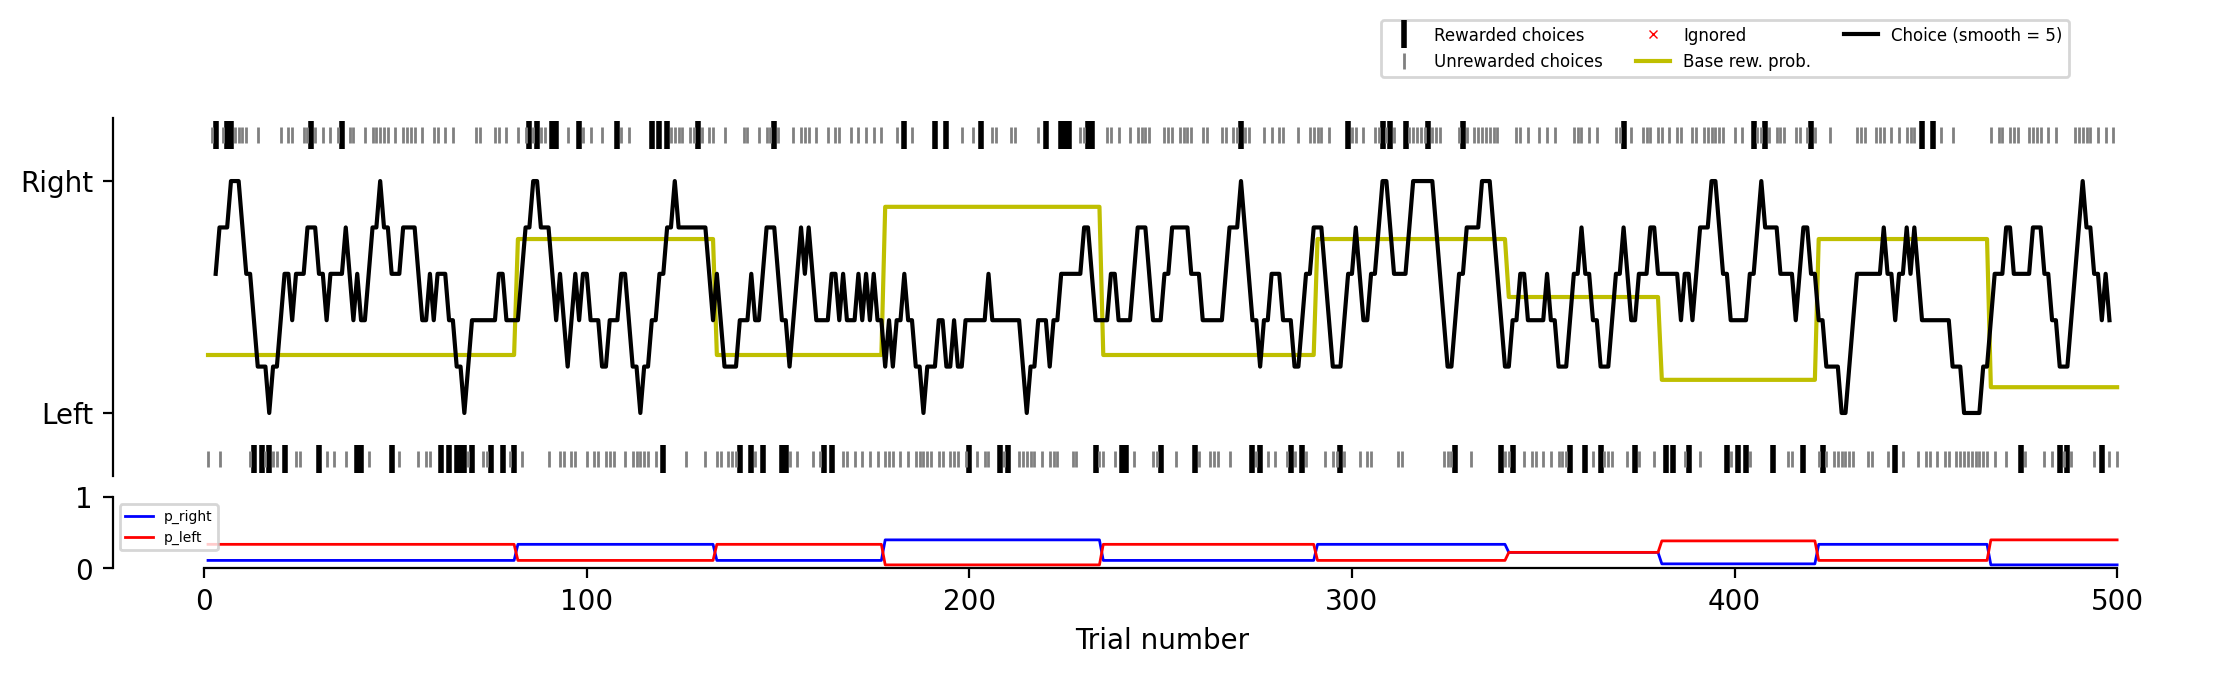

In [6]:
plot_foraging_session(choice_history=actions,
                            reward_history=rewards,
                            p_reward=np.array(env.task.trial_p_reward).T);

### A left-biased agent (with ignore) performing the Uncoupled task

In [7]:
np.random.seed(56)
L, R, IGNORE = 0, 1, 2

task = UncoupledBlockTask(
    rwd_prob_array=[0.1, 0.5, 0.9],
    block_min=20, block_max=35,
    persev_add=True, perseverative_limit=4,
    max_block_tally=4,  # Max number of consecutive blocks in which one side has higher rwd prob than the other
)

env = DynamicBanditEnv(
    task, 
    num_arms=2,
    allow_ignore=True,
    num_trials=1000
)

random_agent = RandomAgent(k_arms=env.action_space.n)

observation, info = env.reset()
done = False
actions = []
rewards = []

while not done:  # Trial loop
    # Choose an action (a random agent with left bias and ignores)
    action = [L, R, IGNORE][np.random.choice([0]*100 + [1]*20 + [2]*1)]
    
    # Can also apply block holde here (optional)
    task.hold_this_block = 500 < task.trial < 700
    
    # Take the action and observe the next observation and reward
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated        
    
    # Move to the next observation
    observation = next_observation
    
    actions.append(action)
    rewards.append(reward)

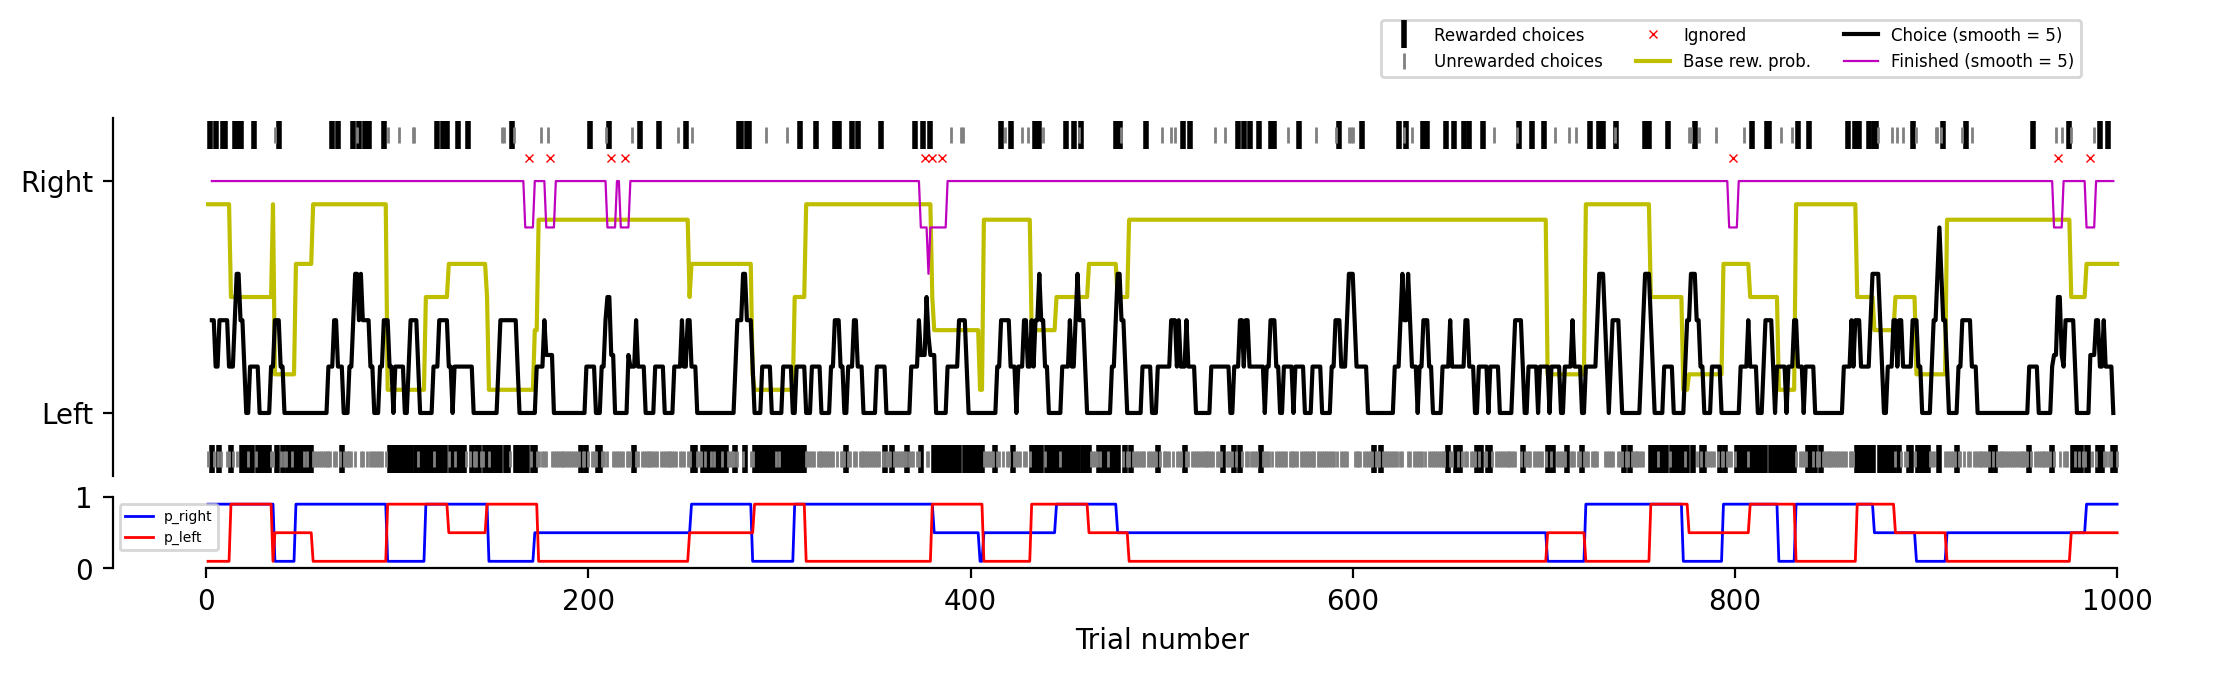

In [8]:
actions = np.array(actions).astype(float)
actions[actions==IGNORE] = np.nan
plot_foraging_session(choice_history=actions,
                      reward_history=rewards,
                      p_reward=np.array(env.task.trial_p_reward).T);

Also show reasons of block transitions

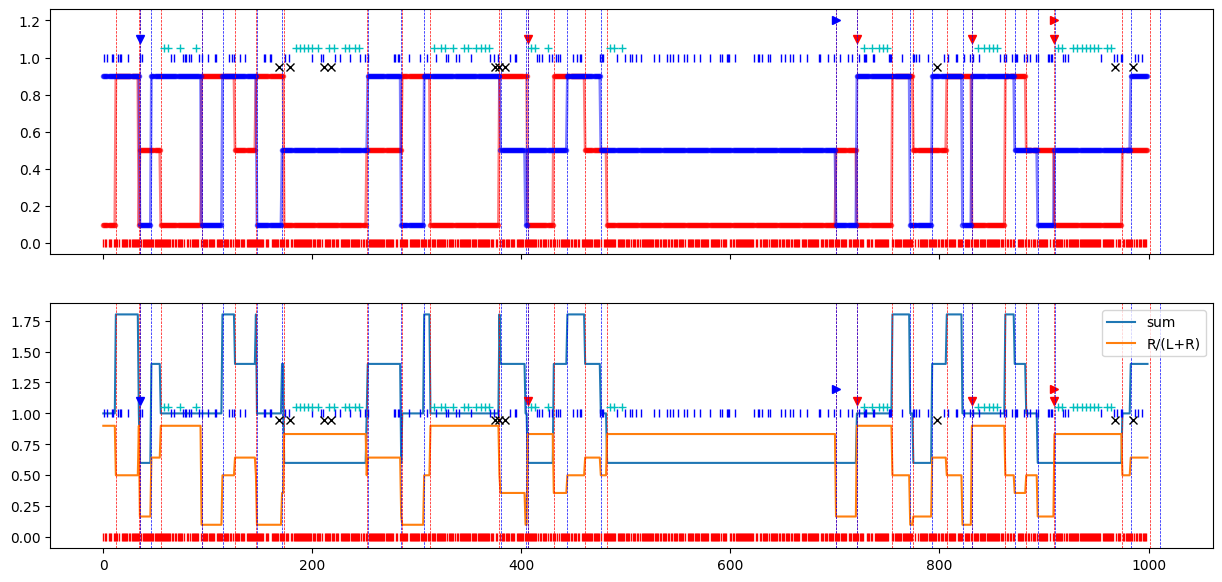

In [17]:
task.plot_reward_schedule()

assert task.block_ends[L] == [12, 34, 35, 55, 94, 126, 146, 173, 252, 286, 313, \
    379, 406, 431, 461, 482, 701, 721, 755, 775, 807, \
        831, 863, 883, 910, 975, 1001]

assert task.block_ends[R] == [35, 46, 94, 114, 147, 171, 253, 285, 307, 380, 404, \
    406, 444, 476, 701, 721, 772, 793, 822, 831, 872, 894, 910, 983, 1011]